In [10]:
!pip install --user -U lightautoml

  Using cached LightAutoML-0.3.1-py3-none-any.whl (293 kB)
  Using cached AutoWoE-1.2.5-py3-none-any.whl (204 kB)
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Using cached poetry_core-1.0.7-py2.py3-none-any.whl (424 kB)
  Using cached json2html-1.3.0-py3-none-any.whl
  Using cached catboost-1.0.1-cp37-none-win_amd64.whl (77.3 MB)
  Using cached holidays-0.11.3.1-py3-none-any.whl (155 kB)
  Using cached hijri_converter-2.2.2-py3-none-any.whl (13 kB)
  Using cached korean_lunar_calendar-0.2.1-py3-none-any.whl (8.0 kB)
  Using cached convertdate-2.3.2-py3-none-any.whl (47 kB)


In [3]:
!pip install --user --upgrade pip

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", rc={'figure.figsize':(16,5)})

from data import preprocessing
from func import get_timestamp

from lightgbm import LGBMRegressor, Booster
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import QuantileTransformer
import optuna

import pickle

submission = False

c:\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
%%time
target_column = 'C'

kwargs = {
          'encode_cat': True}
train_pre, test_pre, num_columns, cat_columns, target = preprocessing(**kwargs)

Чтение закончилось
Int64Index([510008, 510009, 510010, 510011, 510012, 510013, 510014, 510015,
            510016, 510017],
           dtype='int64', name='NPLV')
Int64Index([510008, 510009, 510010, 510011, 510012, 510013, 510014, 510015,
            510016, 510017,
            ...
            512313, 512314, 512315, 512316, 512317, 512318, 512319, 512320,
            512321, 512322],
           dtype='int64', name='NPLV', length=2063)
1
Index(['NPLV', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU', 'V', 'TI',
       'DATA_ZAMERA', 'plavka_VR_NACH', 'plavka_VR_KON', 'plavka_NMZ',
       'plavka_NAPR_ZAD', 'plavka_STFUT', 'plavka_TIPE_FUR', 'plavka_ST_FURM',
       'plavka_TIPE_GOL', 'plavka_ST_GOL', 'TST', 'C', 'plavka_time',
       'timediff_chugun', 'furma_chosen_mean', 'furma_chosen_max', 'VES0',
       'VES1', 'VES2', 'VES3', 'VES4', 'VES5', 'VES6', 'VES7', 'VES8',
       'VSSYP104', 'VSSYP119', 'VSSYP171', 'VSSYP346', 'VSSYP397', 'VSSYP408',
       'VSSYP442', 'index', 'produv

In [7]:
print(target)

['C', 'TST']


In [3]:
import joblib
joblib.dump(train_pre, 'train_pre.pkl')
joblib.dump(test_pre, 'test_pre.pkl')

['test_pre.pkl']

In [14]:
# train_pre = joblib.load('train_pre.pkl')
# test_pre = joblib.load('test_pre.pkl')
# num_columns = ['VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU', 'V', 'TI', 'plavka_STFUT', 'plavka_ST_FURM', 'plavka_ST_GOL', 'plavka_time', 'timediff_chugun', 'furma_chosen_mean', 'furma_chosen_max', 'VES0', 'VES1', 'VES2', 'VES3', 'VES4', 'VES5', 'VES6', 'VES7', 'VSSYP104', 'VSSYP119', 'VSSYP171', 'VSSYP346', 'VSSYP397', 'VSSYP408', 'VSSYP442', 'produv_mean_RAS', 'produv_mean_POL', 'produv_sum_RAS', 'produv_sum_POL', 'produv_min_RAS', 'produv_min_POL', 'produv_max_RAS', 'produv_max_POL', 'produv_std_RAS', 'produv_std_POL', 'produv_amp_RAS', 'produv_amp_POL', 'pressure_mean_O2_pressure', 'pressure_sum_O2_pressure', 'pressure_min_O2_pressure', 'pressure_max_O2_pressure', 'pressure_std_O2_pressure', 'pressure_amp_O2_pressure', 'chronom_O2', 'chronom_produv_timediff', 'O2_volume', 'N2_volume', 'H2_volume', 'CO2_volume', 'CO_volume', 'AR_volume', 'out_C', 'gas_heat', 'time_betw_plavki', 'C_min', 'C_max']
# cat_columns = ['plavka_NMZ', 'plavka_NAPR_ZAD', 'plavka_TIPE_FUR', 'plavka_TIPE_GOL']
# target = ['C', 'TST']

In [8]:
for i in train_pre.columns:
    print(i, end=', ')

NPLV, VES, T, SI, MN, S, P, CR, NI, CU, V, TI, plavka_NMZ, plavka_NAPR_ZAD, plavka_STFUT, plavka_TIPE_FUR, plavka_ST_FURM, plavka_TIPE_GOL, plavka_ST_GOL, TST, C, plavka_time, timediff_chugun, furma_chosen_mean, furma_chosen_max, VES0, VES1, VES2, VES3, VES4, VES5, VES6, VES7, VSSYP104, VSSYP119, VSSYP171, VSSYP346, VSSYP397, VSSYP408, VSSYP442, produv_mean_RAS, produv_mean_POL, produv_sum_RAS, produv_sum_POL, produv_min_RAS, produv_min_POL, produv_max_RAS, produv_max_POL, produv_std_RAS, produv_std_POL, produv_amp_RAS, produv_amp_POL, pressure_mean_O2_pressure, pressure_sum_O2_pressure, pressure_min_O2_pressure, pressure_max_O2_pressure, pressure_std_O2_pressure, pressure_amp_O2_pressure, chronom_O2, chronom_produv_timediff, O2_volume, N2_volume, H2_volume, CO2_volume, CO_volume, AR_volume, out_C, gas_heat, time_betw_plavki, C_min, C_max, 

In [9]:
train_pre.shape

(2059, 71)

In [10]:
train_pre['C'].isna().value_counts()

False    2059
Name: C, dtype: int64

In [11]:
import lightautoml
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [60]:
roles_с = {
    'target': 'C',
    'drop': 'TST',
    'id': 'NPLV'
}

In [61]:
def metric(answers, user_csv):
    delta_c = np.abs(answers - user_csv)
    hit_rate_c = np.int64(delta_c < 0.02)
#     delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
#     hit_rate_t = np.int64(delta_t < 20)
    N = np.size(answers)
    return np.sum(hit_rate_c) / N # np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [62]:
task_с = Task(
    'reg',
    metric = lambda y_true, y_pred: metric(answers=y_true, user_csv=y_pred),
    loss = 'mae',
    greater_is_better = True)

[08:01:21] sklearn doesn't support in general case mae and will not be used.


In [63]:
automl_с = TabularAutoML(
    gpu_ids = 'all',
    task = task_с,
    timeout = 90*60,
    cpu_limit = 12,
    general_params = {
        'use_algos': [ # catboost медленный, лучше не использовать
            ['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned'], # Модели 1-го уровня 
            ['linear_l2', 'lgb_tuned']   # Модели 2-го уровня
        ],
        'skip_conn': True # Использование признаков признаков 1-го уровня в следующих уровнях
    },
    reader_params = {
        'n_jobs': 12,
        'cv': 10,
        'random_state': 42
    },
    cb_params = {'default_params': {'task_type': 'GPU'}}
)

In [64]:
oof_prediction_с = automl_с.fit_predict(
    train_pre, 
    roles=roles_с,
    verbose=3
)

[08:01:44] Stdout logging level is INFO3.
[08:01:44] Task: reg

[08:01:44] Start automl preset with listed constraints:
[08:01:44] - time: 5400.00 seconds
[08:01:44] - CPU: 12 cores
[08:01:44] - memory: 16 GB

[08:01:44] Train data shape: (2059, 71)

[08:01:53] Feats was rejected during automatic roles guess: []
[08:01:53] Layer 1 train process start. Time left 5391.27 secs
[08:01:53] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:01:53] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[08:01:53] Linear model: C = 1e-05 score = 104.0873786407767
[08:01:53] Linear model: C = 5e-05 score = 91.69902912621359
[08:01:53] Linear model: C = 0.0001 score = 88.14563106796116
[08:01:53] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[08:01:53] Linear model: C = 1e-05 score = 108.16990291262135
[08:01:53] Linear model: C = 5e-05 score = 95.49514563106796
[08:01:54] Linear model: C = 0.0001 score = 93.37378640776699
[08:01:54] ===== Start working with

In [65]:
not_nan_с = np.any(~np.isnan(oof_prediction_с.data), axis=1)

In [ ]:
not_nan_с.sum()

In [ ]:
from sklearn.metrics import mean_absolute_error

In [66]:
print("OUT-OF-FOLD")
print(f'MAE: {mean_absolute_error(oof_prediction_с.data[not_nan_с], train_pre["C"][not_nan_с])}')
print(f'Metric: {metric(train_pre["C"][not_nan_с].values, oof_prediction_с.data[not_nan_с].reshape(2059,))}')

OUT-OF-FOLD
MAE: 0.02459509356779459
Metric: 0.7440505099562894


In [54]:
train_pre["C"][not_nan_с].values.shape

(2059,)

In [56]:
oof_prediction_с.data[not_nan_с].reshape(2059,)

array([0.06033713, 0.07172757, 0.06234528, ..., 0.13706012, 0.19512285,
       0.08824759], dtype=float32)

# Для TST

In [67]:
roles_tst = {
    'target': 'TST',
    'drop': 'C',
    'id': 'NPLV'
}

In [68]:
def metric_tst(answers, user_csv):
    delta_t = np.abs(answers - user_csv)
    hit_rate_t = np.int64(delta_t < 20)
    N = np.size(answers)
    return np.sum(hit_rate_t) / N

In [69]:
task_tst = Task(
    'reg',
    metric = lambda y_true, y_pred: metric_tst(answers=y_true, user_csv=y_pred),
    loss = 'mae',
    greater_is_better = True)

[08:16:53] sklearn doesn't support in general case mae and will not be used.


In [ ]:
automl_tst = TabularUtilizedAutoML(
    gpu_ids = 'all',
    task = task_tst,
    timeout = 90*60,
    cpu_limit = 12,
    general_params = {
        'use_algos': [ # catboost медленный, лучше не использовать
            ['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned'], # Модели 1-го уровня 
            ['linear_l2', 'lgb_tuned']   # Модели 2-го уровня
        ],
        'skip_conn': True # Использование признаков признаков 1-го уровня в следующих уровнях
    },
    reader_params = {
        'n_jobs': 12,
        'cv': 10,
        'random_state': 42
    },
    cb_params = {'default_params': {'task_type': 'GPU'}}
)

In [48]:
oof_prediction_tst = automl_tst.fit_predict(
    train_pre, 
    roles=roles_tst,
    verbose=3
)

[05:22:02] [100]	valid's l1: 19.4904	valid's Opt metric: 0.592233
[05:22:03] [200]	valid's l1: 18.0704	valid's Opt metric: 0.665049
[05:22:04] [300]	valid's l1: 17.7651	valid's Opt metric: 0.679612
[05:22:04] [400]	valid's l1: 17.6668	valid's Opt metric: 0.699029
[05:22:05] [500]	valid's l1: 17.6485	valid's Opt metric: 0.68932
[05:22:06] Trial 16 with hyperparameters {'feature_fraction': 0.9996812193207758, 'num_leaves': 114, 'bagging_fraction': 0.7775921640409149, 'min_sum_hessian_in_leaf': 7.157660062419457, 'reg_alpha': 3.3070708222580573e-07, 'reg_lambda': 0.019715794207991112} scored 0.6990291262135923 in 0:00:03.616326
[05:22:06] [1]	valid's l1: 24.445	valid's Opt metric: 0.470874
[05:22:06] Training until validation scores don't improve for 200 rounds
[05:22:06] [100]	valid's l1: 19.6543	valid's Opt metric: 0.597087
[05:22:07] [200]	valid's l1: 18.1393	valid's Opt metric: 0.65534
[05:22:07] [300]	valid's l1: 17.7584	valid's Opt metric: 0.660194
[05:22:07] [400]	valid's l1: 17.57

In [49]:
not_nan_tst = np.any(~np.isnan(oof_prediction_tst.data), axis=1)

In [71]:
from sklearn.metrics import mean_absolute_error
print("OUT-OF-FOLD")
print(f'MAE: {mean_absolute_error(oof_prediction_tst.data[not_nan_tst], train_pre["TST"][not_nan_tst])}')
print(f'Metric: {metric_tst(train_pre["TST"][not_nan_tst].values, oof_prediction_tst.data[not_nan_tst].reshape(2059,))}')

OUT-OF-FOLD
MAE: 16.58422614417648
Metric: 0.6920835356969403


array([[1650.2375],
       [1650.4045],
       [1654.084 ],
       [1656.3733],
       [1656.3724],
       [1656.6345],
       [1654.709 ],
       [1653.8912],
       [1651.832 ],
       [1642.4799],
       [1657.4429],
       [1664.744 ],
       [1653.7094],
       [1665.346 ],
       [1662.6686],
       [1665.2224],
       [1668.1465],
       [1646.3541],
       [1665.2435],
       [1659.4779],
       [1664.4669],
       [1654.1742],
       [1656.1283],
       [1663.963 ],
       [1654.1416],
       [1650.4808],
       [1654.6174],
       [1655.4924],
       [1654.9144],
       [1650.5349],
       [1654.2041],
       [1657.8405],
       [1643.5475],
       [1657.5215],
       [1663.4784],
       [1665.4447],
       [1660.3944],
       [1667.686 ],
       [1650.6407],
       [1661.3033],
       [1658.9347],
       [1659.9697],
       [1659.4482],
       [1661.9799],
       [1652.166 ],
       [1653.9977],
       [1657.0377],
       [1649.4951],
       [1662.6262],
       [1661.4454],


In [72]:
submission = pd.read_csv('data/sample_submission.csv')
submission['TST'] = automl_tst.predict(test_pre).data
submission['C'] = automl_с.predict(test_pre).data
submission.sample()

,NPLV,TST,C
578,513118,1650.314209,4.956223


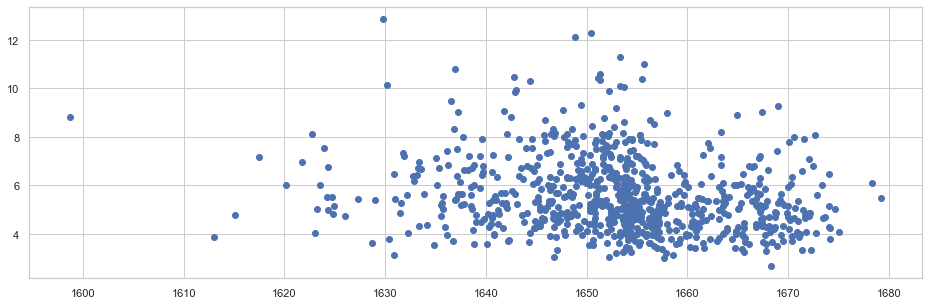

In [73]:
import matplotlib.pyplot as plt
plt.scatter(submission['TST'], submission['C'])

In [74]:
submission.to_csv('submission_8-20.csv', index=False)

In [34]:
automl_tst_backup = automl_tst
automl_с_backup = automl_с

In [55]:
automl_tst_backup_2 = automl_tst
automl_с_backup_2 = automl_с